<a href="https://colab.research.google.com/github/1HPz/Statistical-Learning-Labs/blob/main/Predict_Rain_Level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Rain_Volume_in_Chiangmai.csv')
df.head()


Mounted at /content/drive


,ปี-เดือน,ปริมาณน้ำฝน
0,2556-01,0.81
1,2556-02,1.13
2,2556-03,0.55
3,2556-04,0.04
4,2556-05,2.90


# **Check Stationarity**

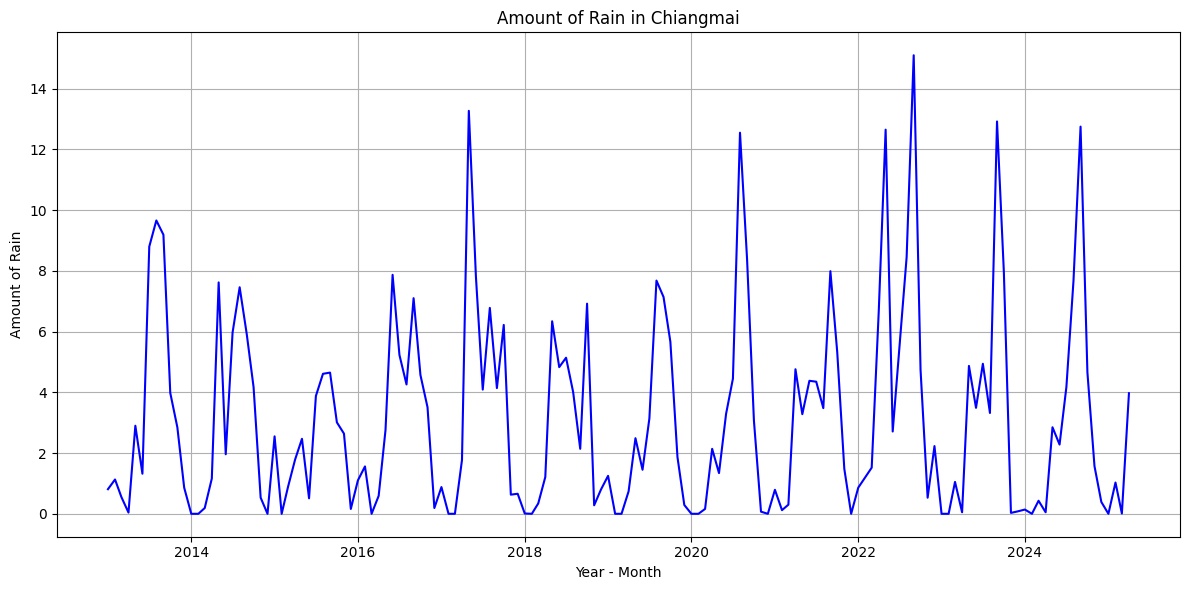

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# แปลงพ.ศ. เป็น ค.ศ.
df['ปี-เดือน'] = df['ปี-เดือน'].apply(lambda x: str(int(x[:4]) - 543) + x[4:])

# แปลงเป็น datetime
df['ปี-เดือน'] = pd.to_datetime(df['ปี-เดือน'], format='%Y-%m', errors='coerce')

# แปลงปริมาณน้ำฝนให้เป็นตัวเลข
df['ปริมาณน้ำฝน'] = pd.to_numeric(df['ปริมาณน้ำฝน'], errors='coerce')

# ลบข้อมูลที่แปลงไม่สำเร็จ
df = df.dropna(subset=['ปี-เดือน', 'ปริมาณน้ำฝน'])

# พล็อตกราฟ
plt.figure(figsize=(12, 6))
plt.plot(df['ปี-เดือน'], df['ปริมาณน้ำฝน'], linestyle='-', color='blue')
plt.xlabel('Year - Month')
plt.ylabel('Amount of Rain')
plt.title('Amount of Rain in Chiangmai')
plt.grid(True)
plt.tight_layout()
plt.show()


**ADF test**

In [3]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['ปริมาณน้ำฝน'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.285277736399023
p-value: 0.17676016591404803


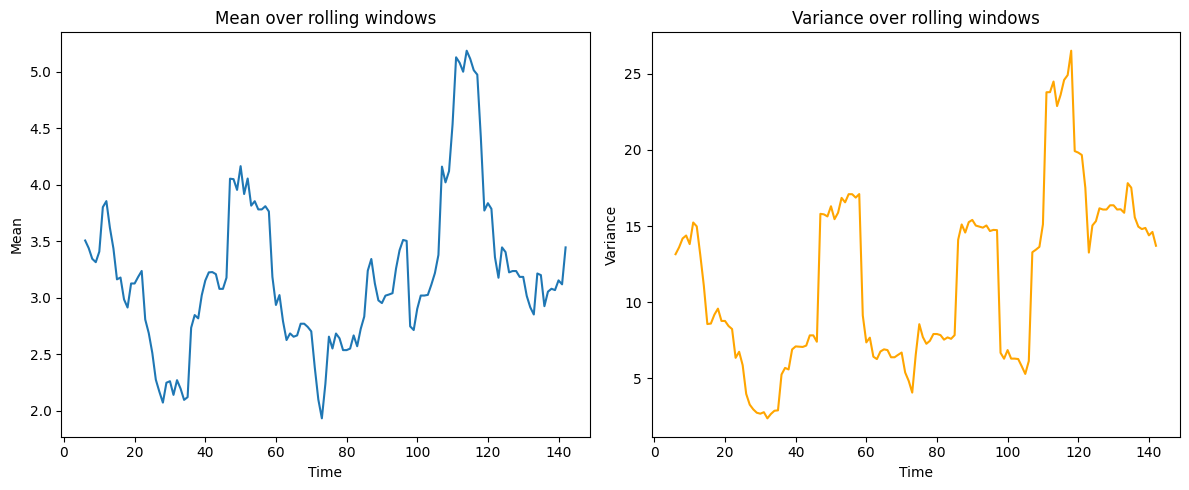

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# สมมติ df.index เป็น datetime และมีคอลัมน์ 'value' หรือเปลี่ยนเป็นชื่อคอลัมน์ของคุณ
series = df['ปริมาณน้ำฝน']

# กำหนดขนาด window เป็นจำนวนเดือน เช่น 12 เดือน (1 ปี)
window_size = 12

# สร้าง lists เก็บค่า mean และ variance ของแต่ละ window
means = []
variances = []
window_centers = []

for start in range(len(series) - window_size + 1):
    window = series.iloc[start:start + window_size]
    means.append(window.mean())
    variances.append(window.var())
    window_centers.append(window.index[window_size // 2])  # เก็บตำแหน่งกลาง window

# แปลงเป็น Series เพื่อ plot
means = pd.Series(means, index=window_centers)
variances = pd.Series(variances, index=window_centers)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(means, marker='')
plt.title('Mean over rolling windows')
plt.xlabel('Time')
plt.ylabel('Mean')

plt.subplot(1,2,2)
plt.plot(variances, marker='', color='orange')
plt.title('Variance over rolling windows')
plt.xlabel('Time')
plt.ylabel('Variance')

plt.tight_layout()
plt.show()


**Transforming to Stationary**

In [5]:
df['y_diff1'] = df['ปริมาณน้ำฝน'] - df['ปริมาณน้ำฝน'].shift(1)  # First order differencing

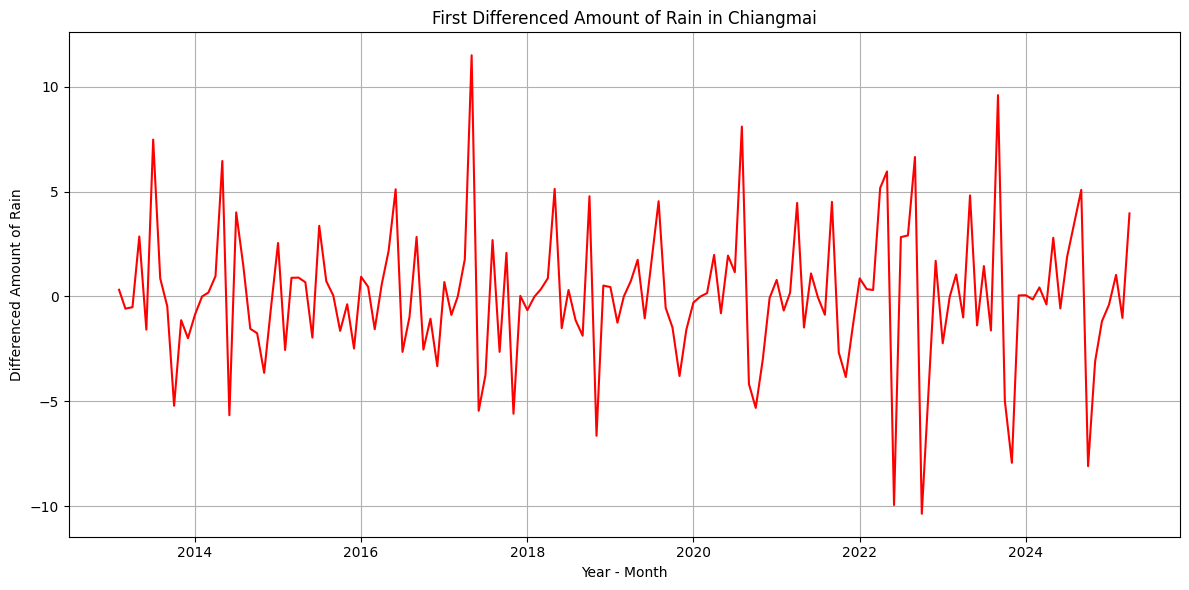

In [6]:
# prompt: พล็อตกราฟหลังจากที่ดิฟแล้ว

import matplotlib.pyplot as plt
# Plot the differenced data
plt.figure(figsize=(12, 6))
plt.plot(df['ปี-เดือน'], df['y_diff1'], linestyle='-', color='red')
plt.xlabel('Year - Month')
plt.ylabel('Differenced Amount of Rain')
plt.title('First Differenced Amount of Rain in Chiangmai')
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# ทำ ADF test อีกครั้งกับข้อมูลที่ differenced
result_diff = adfuller(df['y_diff1'].dropna())
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value (Differenced):', result_diff[1])

# ตีความ p-value
alpha = 0.05
if result_diff[1] <= alpha:
    print("p-value <= alpha (", alpha, "): Reject the null hypothesis (H0). The data is stationary.")
else:
    print("p-value > alpha (", alpha, "): Fail to reject the null hypothesis (H0). The data is non-stationary.")

ADF Statistic (Differenced): -12.088999431240106
p-value (Differenced): 2.1442534580916813e-22
p-value <= alpha ( 0.05 ): Reject the null hypothesis (H0). The data is stationary.


# **ARIMA Model**

**Analyze ACF and PACF to Choose Lag Parameters**

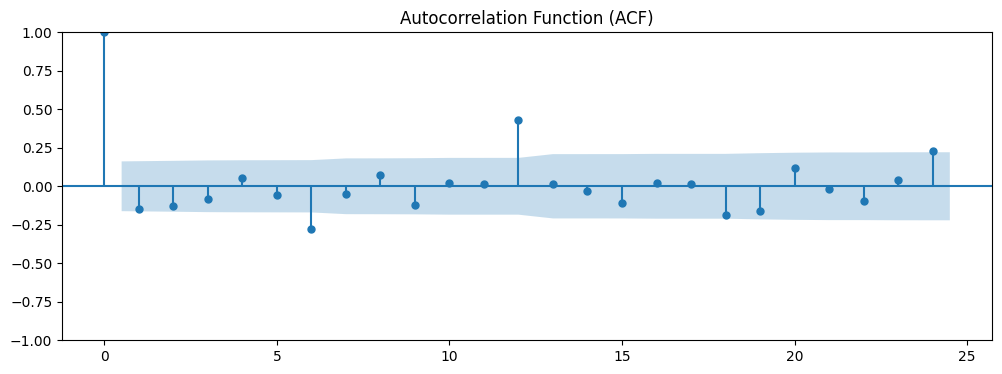

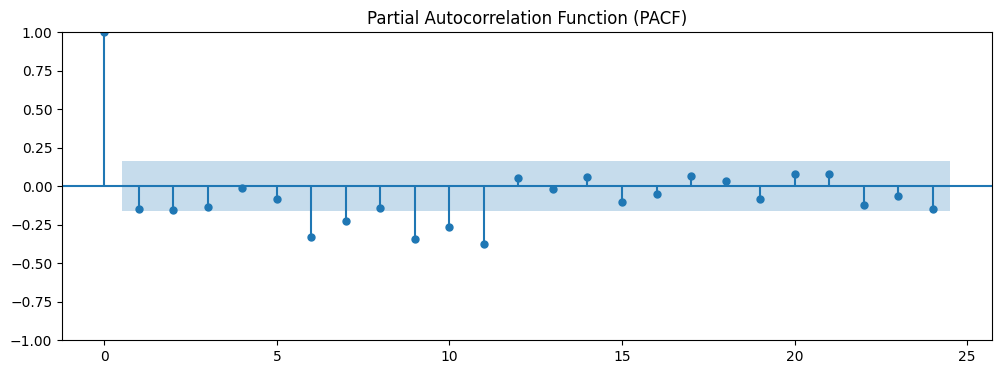

In [11]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming 'df' is your DataFrame and 'y_diff1' is the differenced stationary series
# Drop the first row as it will be NaN after differencing
stationary_series = df['y_diff1'].dropna()

# Plot ACF
fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(stationary_series, ax=ax, lags=24) # You can adjust the number of lags
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
fig, ax = plt.subplots(figsize=(12, 4))
plot_pacf(stationary_series, ax=ax, lags=24) # You can adjust the number of lags
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()